## Control: Correlate cost profiles with shuffled sequences

```bash
python scripts/extract_attention_patterns_shuffled.py \
  -c results/20240528_151534/experiment_config.yaml
```

In [1]:
import os
from multiprocessing import cpu_count
import yaml

import h5py
import numexpr
import numpy as np
import pandas as pd
import requests
import scipy as sci
import scipy.signal as signal
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scripts.general import attribution, data

numexpr.set_num_threads(cpu_count() - 4)
# pd.set_option('compute.use_numba', True)


def left_align(df: pd.DataFrame):
    """https://stackoverflow.com/a/63869860"""
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

AAindex calculations and correlation filtering was performed in the `physical_profiles.Rmd` notebook.

Index values for all proteins were saved to `../data/protein_features/uncorr_aaindex_profiles.h5`

**Note** Corr performed with unfiltered profiles, since small attention values might be relevant in relation to AAindex, and unclear what a baseline of noise might be (plus, it should not correlate).

In [2]:
aaindex_profiles_fname = '../../data/protein_features/uncorr_aaindex_profiles.h5'

with h5py.File(aaindex_profiles_fname, 'r') as store:
    probe_id = list(store.keys())[0]
    aa_indices = list(store[probe_id].keys())

print(aa_indices)

['BUNA790103', 'FINA910104', 'GEOR030103', 'GEOR030104', 'LEVM760103', 'MITS020101', 'NADH010107', 'NAKH920107', 'PALJ810107', 'QIAN880138', 'RICJ880104', 'RICJ880117', 'ROBB760107', 'TANS770102', 'TANS770108', 'VASM830101', 'WERD780103', 'WOEC730101']


In [3]:
request_aa = requests.get('https://www.genome.jp/aaindex/AAindex/list_of_indices')

aaindex_names = {}

for entry in request_aa.text.splitlines()[5:]:
    idx_name, descr = entry.split(' ', maxsplit=1)
    aaindex_names[idx_name] = descr

In [4]:
with open('experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
    
seq_and_abundances = data.load_seq_and_abundance_data(config)[
    ['swissprot_ac', 'seq', 'Median_molecules_per_cell']
]
seq_and_abundances = seq_and_abundances.assign(length = seq_and_abundances['seq'].str.len())
seq_and_abundances = (
    seq_and_abundances
    .sort_values('swissprot_ac')
    .assign(prot_idx = np.arange(seq_and_abundances.shape[0]))
)

In [5]:
print('N. seq: ', seq_and_abundances.shape[0])

N. seq:  4750


In [6]:
print('Bonferroni-corrected p-values =', 0.05 / seq_and_abundances.shape[0])

Bonferroni-corrected p-values = 1.0526315789473684e-05


In [7]:
pvalue_threshold = 0.05 / seq_and_abundances.shape[0]

pvalue_threshold = 1e6

In [ ]:
exp_dir = '.'

def get_aaindex_for_protein(protein_id: str, aaindex: str) -> np.array:
    with h5py.File(aaindex_profiles_fname, 'r') as store:
         index_values = np.array(store[protein_id][aaindex]['ELT1'])
    return index_values


def calc_profile_attention_corr(protein_id: str, aaindex: str) -> float:
    """
    Return highest absolute correlation between any of the proteins attention profiles
    and the protein's AAindex values
    """
    index_values = get_aaindex_for_protein(protein_id, aaindex)
    
    # Multiple profiles for a sequence
    attention_profiles, _ = attribution.load_profiles(protein_id, exp_dir)
    
    # Calc corr between aaindex and all profiles
    attention_corr = np.apply_along_axis(
        lambda profile: stats.pearsonr(profile, index_values),
        axis = 1,
        arr = attention_profiles
    )
    
    # Keep only significant corr (low p-value) with Bonferroni correction
    signif_att_corr = attention_corr[attention_corr[:, 1] < pvalue_threshold]
    signif_att_corr = signif_att_corr[:, 0]

    # Return max absolute value
    if signif_att_corr.shape[0] > 0:
        
        argmax_pval = np.argmax(np.abs(signif_att_corr.ravel()))
        pvals.append(
            (aaindex, attention_corr[attention_corr[:, 1] < pvalue_threshold][argmax_pval, 1])
        )
        
        return max(signif_att_corr.min(), signif_att_corr.max(), key=abs)
    else:
        return None

# calc_profile_attention_corr('A2P2R3', 'ZIMJ680104')   # TEST

In [9]:
tqdm.pandas(desc="corr calc")

pvals = []

for aaindex in tqdm(aa_indices, desc="AA indices"):
    seq_and_abundances[aaindex] = seq_and_abundances['swissprot_ac'].apply(
            lambda prot_id: calc_profile_attention_corr(prot_id, aaindex)
        )
    
pvals = pd.DataFrame.from_records(pvals, columns = ['AAindex', 'p-value'])

AA indices: 100%|██████████| 18/18 [12:56<00:00, 43.14s/it]


In [10]:
attention_correlations = seq_and_abundances

In [11]:
attention_correlations = attention_correlations.drop(
    columns = ['seq', 'length', 'Median_molecules_per_cell', 'prot_idx']
)
attention_correlations = pd.melt(
    attention_correlations,
    id_vars='swissprot_ac',
    value_vars=attention_correlations.drop(columns='swissprot_ac').columns.values,
    var_name = 'AAindex'
)
attention_correlations = attention_correlations.assign(
    desc = attention_correlations['AAindex'].apply(lambda aai: aaindex_names[aai])
)

In [15]:
attention_correlations['value'].abs().mean()

0.07996081764744818

In [16]:
attention_correlations['value'].abs().std()

0.04309726745919149

In [17]:
attention_correlations.to_csv('shuffled_attention_aaindex_corr.csv.gz', index=False, compression='gzip')

In [3]:
attention_correlations = pd.read_csv('shuffled_attention_aaindex_corr.csv.gz')

In [4]:
CORR_THRESHOLD = 0.0

mean_att_cor = (attention_correlations
                .groupby('AAindex').apply(lambda grp_df: grp_df['value'].abs().mean())
               )
mean_att_cor = mean_att_cor.rename('value').reset_index()
hi_att_corr_aa_indices = mean_att_cor.query(f'value > {CORR_THRESHOLD}')['AAindex'].values
hi_corr_vals = attention_correlations[attention_correlations['AAindex'].isin(hi_att_corr_aa_indices)]

In [5]:
hi_corr_vals.head()

,swissprot_ac,AAindex,value,desc
0,A2P2R3,BUNA790103,0.126509,Spin-spin coupling constants 3JHalpha-NH (Bund...
1,D6VPM8,BUNA790103,-0.126199,Spin-spin coupling constants 3JHalpha-NH (Bund...
2,D6VTK4,BUNA790103,0.062179,Spin-spin coupling constants 3JHalpha-NH (Bund...
3,D6W196,BUNA790103,-0.052573,Spin-spin coupling constants 3JHalpha-NH (Bund...
4,O13297,BUNA790103,-0.040664,Spin-spin coupling constants 3JHalpha-NH (Bund...


Text(0.5, 0, 'Pearson corr between AAindex and attention profiles')

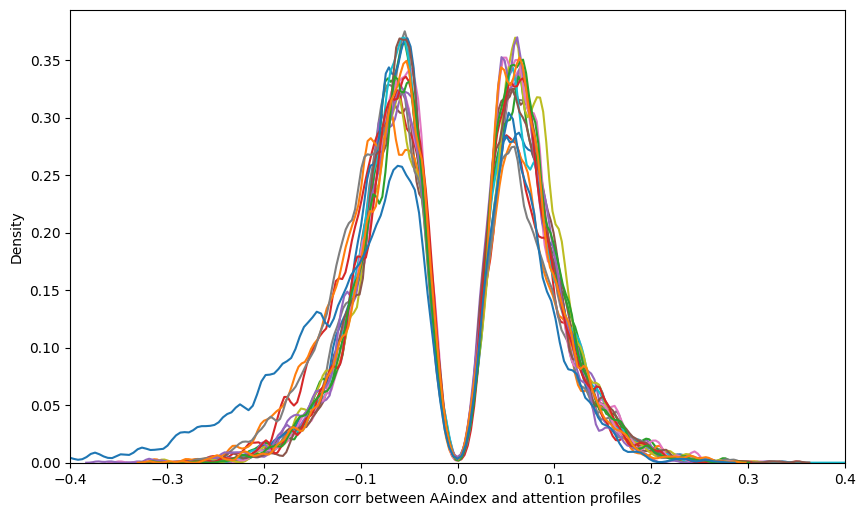

In [7]:
plt.figure(dpi = 100, figsize = (10, 6))


splot = sns.kdeplot(hi_corr_vals, 
                    x = 'value', hue='AAindex', 
                    legend=False,
                    bw_adjust = 0.25,
                    palette = 'tab10')

splot.set(xlim=(-0.4, 0.4))
plt.xlabel('Pearson corr between AAindex and attention profiles')

## Overlap with correlations of real sequences

In [8]:
real_corr = pd.read_csv('../20211223_182228/aaindex_hi_corr_vals.csv').assign(group='proteins')

In [11]:
from collections import defaultdict

id_type_mapping = {
    'WERD780103': 'backbone conformation propensity',
    'TANS770108': 'backbone conformation propensity',
    'VASM830101': 'backbone conformation propensity',
    'TANS770102': 'backbone conformation propensity',
    'GEOR030103': 'domain linker propensity',
    'RICJ880104': 'preference for position at α-helix cap',
    'RICJ880117': 'preference for position at α-helix cap',
    'WOEC730101': 'polarity',
    'MITS020101': 'polarity',
    'NAKH920107': 'extracellular AA%',
}


palette = sns.color_palette('tab10')

aaidx_colors = {
    'backbone conformation propensity':       sns.color_palette(palette)[0],
    'polarity':                               sns.color_palette(palette)[1],
    'domain linker propensity':               '#555555',
    'preference for position at α-helix cap': sns.color_palette(palette)[3],
    'extracellular AA%':                      sns.color_palette(palette)[4]
}

property_type = defaultdict(lambda: 'other')
for k, v in id_type_mapping.items():
    property_type[k] = v

plot_type_names = list(map(lambda aaidx: property_type[aaidx], real_corr['AAindex'].unique()))
plot_type_colors = list(map(lambda aaidx_type: aaidx_colors[aaidx_type], plot_type_names))

In [12]:
corr_index_ranking = pd.merge(
    (real_corr.groupby('AAindex')
         .apply(lambda grp_df: grp_df['value'].abs().mean())
         .rename('abs_mean').reset_index()
         .sort_values('abs_mean', ascending=False)
    ),
    real_corr[['AAindex', 'desc']].drop_duplicates(),
    on='AAindex'
)

corr_index_ranking = corr_index_ranking.assign(
    index_type = corr_index_ranking['AAindex'].map(id_type_mapping.get)
)

corr_index_ranking

,AAindex,abs_mean,desc,index_type
0,WERD780103,0.383221,Free energy change of alpha(Ri) to alpha(Rh) (...,backbone conformation propensity
1,TANS770108,0.378532,Normalized frequency of zeta R (Tanaka-Scherag...,backbone conformation propensity
2,VASM830101,0.369834,Relative population of conformational state A ...,backbone conformation propensity
3,RICJ880104,0.368836,Relative preference value at N1 (Richardson-Ri...,preference for position at α-helix cap
4,WOEC730101,0.348673,"Polar requirement (Woese, 1973)",polarity
5,TANS770102,0.341910,Normalized frequency of isolated helix (Tanaka...,backbone conformation propensity
6,NAKH920107,0.336049,AA composition of EXT of multi-spanning protei...,extracellular AA%
7,RICJ880117,0.320519,"Relative preference value at C"" (Richardson-Ri...",preference for position at α-helix cap
8,GEOR030103,0.311132,Linker propensity from 2-linker dataset (Georg...,domain linker propensity
9,MITS020101,0.310095,"Amphiphilicity index (Mitaku et al., 2002)",polarity


In [13]:
corr_index_means = pd.merge(
    (
        real_corr
        .groupby('AAindex')['value']
        .mean()
        .rename('mean_corr').reset_index()
        .sort_values('mean_corr', ascending=False)
    ),
    real_corr[['AAindex', 'desc']].drop_duplicates(),
    on='AAindex'
)

corr_index_means = corr_index_means.assign(
    index_type = corr_index_means['AAindex'].map(id_type_mapping.get)
)

left_align(
    corr_index_means
)

,AAindex,mean_corr,desc,index_type
0,RICJ880104,0.368029,"Relative preference value at N1 (Richardson-Richardson, 1988)",preference for position at α-helix cap
1,WOEC730101,0.348570,"Polar requirement (Woese, 1973)",polarity
2,MITS020101,0.305923,"Amphiphilicity index (Mitaku et al., 2002)",polarity
3,TANS770108,0.304256,"Normalized frequency of zeta R (Tanaka-Scheraga, 1977)",backbone conformation propensity
4,VASM830101,0.301944,"Relative population of conformational state A (Vasquez et al., 1983)",backbone conformation propensity
5,NAKH920107,-0.119901,"AA composition of EXT of multi-spanning proteins (Nakashima-Nishikawa, 1992)",extracellular AA%
6,RICJ880117,-0.168564,"Relative preference value at C"" (Richardson-Richardson, 1988)",preference for position at α-helix cap
7,GEOR030103,-0.266115,"Linker propensity from 2-linker dataset (George-Heringa, 2003)",domain linker propensity
8,TANS770102,-0.337806,"Normalized frequency of isolated helix (Tanaka-Scheraga, 1977)",backbone conformation propensity
9,WERD780103,-0.381838,"Free energy change of alpha(Ri) to alpha(Rh) (Wertz-Scheraga, 1978)",backbone conformation propensity


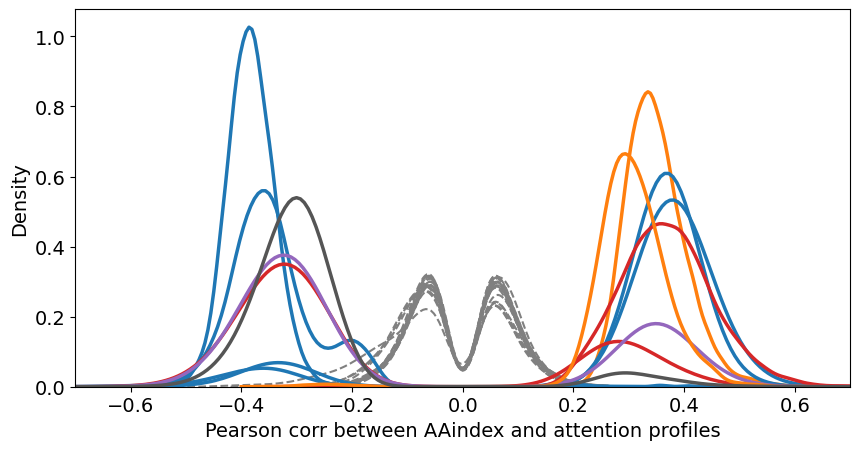

In [37]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 14


bw_adjust = 1


control_palette = sns.color_palette(['grey'], len(hi_corr_vals['AAindex'].unique()))

splot = sns.kdeplot(hi_corr_vals, 
                    x = 'value', hue='AAindex',
                    bw_adjust = bw_adjust,
                    ls='--',
                    palette = control_palette,
                    legend=False)


splot = sns.kdeplot(real_corr, 
                    x = 'value', hue='AAindex',
                    palette = sns.color_palette(plot_type_colors),
                    bw_adjust = bw_adjust,
                    linewidth = 2.5,
                    legend=False)
plt.xlim(-0.7, 0.7)
plt.xlabel('Pearson corr between AAindex and attention profiles');

# plt.legend(title='AAindex type', loc='upper right', bbox_to_anchor = (1.5, 1),
#            fontsize='small', edgecolor='black',
#            labels=aaidx_colors.keys(),
#            labelcolor=aaidx_colors.values(),
#            handlelength=0)

plt.savefig('aaindex_corr_with_controls.pdf', dpi=100)